In [15]:
import FinanceDataReader as fdr
import torch
import torch.optim
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 로드 및 스케일링

In [3]:
# 삼성전자 데이터 22년 5월~24년 5월까지 로드
df = fdr.DataReader('005930', '2022-05-01', '2024-05-01')
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-05-02,66600,67600,66500,67300,14106184,-0.001484
2022-05-03,67400,68400,67300,67500,14168875,0.002972
2022-05-04,68000,68400,67500,67900,11505248,0.005926
2022-05-06,67000,67100,66500,66500,14356156,-0.020619
2022-05-09,66300,66900,66100,66100,11858736,-0.006015


In [15]:
print(df.shape)

(493, 6)


In [4]:
# 데이터 전처리 : 0~1 값으로 변환
def MinMaxScaler(data):
    n1 = data - np.min(data, 0)
    n2 = np.max(data, 0) - np.min(data, 0)
    return n1 / (n2+1e-7) # 0으로 나누는 것 방지

df = df[['Open', 'High', 'Low', 'Volume', 'Close']]
dfx_origin = df[['Open', 'High', 'Low', 'Volume']]
dfy_origin = df[['Close']]

df1 = MinMaxScaler(df)
dfy = df1[['Close']]
dfx = df1[['Open', 'High', 'Low', 'Volume']]
dfx

,Open,High,Low,Volume
Date,,,,
2022-05-02,0.434650,0.432099,0.449541,0.160588
2022-05-03,0.458967,0.456790,0.474006,0.161796
2022-05-04,0.477204,0.456790,0.480122,0.110496
2022-05-06,0.446809,0.416667,0.449541,0.165402
2022-05-09,0.425532,0.410494,0.437309,0.117304
...,...,...,...,...
2024-04-24,0.765957,0.777778,0.776758,0.315816
2024-04-25,0.759878,0.737654,0.749235,0.188378
2024-04-26,0.775076,0.750000,0.755352,0.134578


In [20]:
X = dfx.values.tolist()
y = dfy.values.tolist()
X[:5]

[[0.43465045592573054,
  0.43209876543076514,
  0.44954128440229496,
  0.16058824694024032],
 [0.458966565348149,
  0.4567901234553803,
  0.4740061162065015,
  0.1617956224870173],
 [0.4772036474149629,
  0.4567901234553803,
  0.4801223241575531,
  0.11049642315162764],
 [0.44680851063693977,
  0.41666666666538066,
  0.44954128440229496,
  0.1654024958783484],
 [0.4255319148923236,
  0.4104938271592269,
  0.4373088685001917,
  0.11730430254865591]]

In [21]:
y[:5]

[[0.44954128440229496],
 [0.4556574923533466],
 [0.46788990825544985],
 [0.42507645259808846],
 [0.4128440366959852]]

## 데이터 전처리 - 10일간의 데이터와 다음 날의 종가 구성하기

In [27]:
# 10일간의 데이터로 종가 예측
window = 10
data_X = []
data_y = []
for i in range(len(y)-window):
    X_ = X[i:i+window] # 10일간의 데이터
    y_ = y[i+window] # 다음 날 종가
    data_X.append(X_)
    data_y.append(y_)
print(X_, "->", y_)

[[0.878419452884868, 0.8549382716022995, 0.8440366972451252, 0.5042420402499336], [0.8632218844958565, 0.8395061728369151, 0.8287461773674961, 0.3243959501545387], [0.8054711246176125, 0.8179012345653768, 0.8103975535143413, 0.3004868482712324], [0.790273556228601, 0.7746913580223003, 0.749235474003825, 0.49206482461344286], [0.7629179331283802, 0.7376543209853776, 0.7125382262975152, 0.47573140677094716], [0.7325227963503571, 0.7160493827138393, 0.7247706421996184, 0.24940211886117347], [0.7659574468061825, 0.7777777777753773, 0.7767584097835573, 0.31581636351604586], [0.7598784194505779, 0.7376543209853776, 0.749235474003825, 0.1883782414405966], [0.7750759878395894, 0.7499999999976852, 0.7553516819548766, 0.13457770186076518], [0.7629179331283802, 0.7407407407384545, 0.7461773700282991, 0.17134043934441504]] -> [0.7614678899059282]


In [28]:
data_X[0] # 10일간의 데이터

[[0.43465045592573054,
  0.43209876543076514,
  0.44954128440229496,
  0.16058824694024032],
 [0.458966565348149,
  0.4567901234553803,
  0.4740061162065015,
  0.1617956224870173],
 [0.4772036474149629,
  0.4567901234553803,
  0.4801223241575531,
  0.11049642315162764],
 [0.44680851063693977,
  0.41666666666538066,
  0.44954128440229496,
  0.1654024958783484],
 [0.4255319148923236,
  0.4104938271592269,
  0.4373088685001917,
  0.11730430254865591],
 [0.4133738601811144,
  0.3919753086407655,
  0.4128440366959852,
  0.22085824408449303],
 [0.4012158054699051,
  0.3919753086407655,
  0.4097859327204594,
  0.12639816634376747],
 [0.39209726443649817,
  0.3672839506161503,
  0.4006116207938819,
  0.20503844858742165],
 [0.3951367781143005,
  0.40432098765307306,
  0.4097859327204594,
  0.16916534914802484],
 [0.4498480243147421,
  0.4259259259246113,
  0.4373088685001917,
  0.11882228971142911]]

In [24]:
data_y[0]

[0.45871559632887243]

## 훈련 데이터와 테스트 데이터 분리

In [29]:
print('전체 데이터 크기 :', len(data_X), len(data_y))

전체 데이터 크기 : 483 483


In [32]:
# 7:3 비율로 분리
train_size = int(len(data_y) * 0.7)
train_X = np.array(data_X[:train_size])
train_y = np.array(data_y[:train_size])

test_size = int(len(data_y) * 0.3)
test_X = np.array(data_X[train_size:])
test_y = np.array(data_y[train_size:])

print('훈련 데이터 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터 크기 :', test_X.shape, test_y.shape)

훈련 데이터 크기 : (338, 10, 4) (338, 1)
테스트 데이터 크기 : (145, 10, 4) (145, 1)


In [78]:
# 텐서로 변환
train_X_tensor = torch.FloatTensor(train_X)
train_y_tensor = torch.FloatTensor(train_y)
test_X_tensor = torch.FloatTensor(test_X)
test_y_tensor = torch.FloatTensor(test_y)

dataset = TensorDataset(train_X_tensor, train_y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

In [60]:
a = next(iter(dataloader))
a[0].shape

torch.Size([32, 10, 4])

## 모델 학습

In [68]:
class MyLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, seq_len, layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers, dropout=0.1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.layers, self.seq_len, self.hidden_dim),
            torch.zeros(self.layers, self.seq_len, self.hidden_dim)
        )
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:,-1])
        return x

In [98]:
def train(model, train_df, epochs=None, lr=None, verbose=10):
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    epochs = epochs
    train_hist = np.zeros(epochs)
    
    for epoch in range(epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):
            x, y = samples
            x = x.to(device)
            y = y.to(device)
            model.reset_hidden_state()
            outputs = model(x)
            loss = criterion(outputs, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_cost += loss
        train_hist[epoch] = avg_cost/total_batch
        
        if epoch%verbose==0: # verbose번째 마다 출력
            print(f'Epoch: {epoch:d}, train_loss: {avg_cost:.4f}')
    return model.eval(), train_hist

In [99]:
seq_len = 10
in_dim = 4
h_dim = 10
out_dim = 1
lr = 0.01
epochs = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyLSTM(in_dim, h_dim, out_dim, seq_len, 1).to(device)
model_trained, train_hist = train(model, dataloader, epochs=epochs, lr=lr, verbose=20)

Epoch: 0, train_loss: 0.2903
Epoch: 20, train_loss: 0.0111
Epoch: 40, train_loss: 0.0097
Epoch: 60, train_loss: 0.0099
Epoch: 80, train_loss: 0.0098


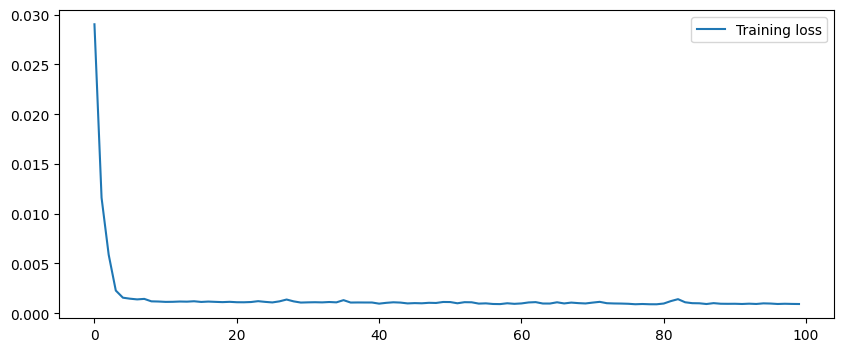

In [100]:
fig = plt.figure(figsize=(10,4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [101]:
# 모델 저장
PATH = "./LSTM_result.pth"
torch.save(model.state_dict(), PATH)

In [102]:
# 모델 불러오기
model = MyLSTM(in_dim, h_dim, out_dim, seq_len, 1).to(device)
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

MyLSTM(
  (lstm): LSTM(4, 10, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

## 다음 날 주가 예측

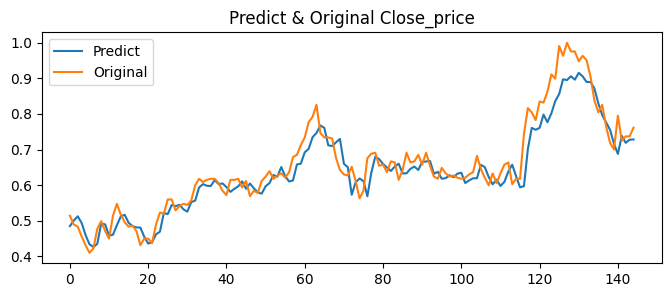

내일 주가 : 74107원


In [125]:
with torch.no_grad():
    pred_hist = []
    for p in range(len(test_X_tensor)):
        model.reset_hidden_state()
        x = torch.unsqueeze(test_X_tensor[p], 0).to(device)
        pred = model(x)
        pred = torch.flatten(pred).item()
        pred_hist.append(pred)
    
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_hist)), pred_hist, label='Predict')
plt.plot(np.arange(len(test_y)), test_y, label='Original')
plt.title('Predict & Original Close_price')
plt.legend()
plt.show()

# origin_y : scaled_y = pred_y : scaled_pred_y 
# pred_y = origin_y * scaled_pred_y / scaled_y
pred_y = dfy_origin.Close[-1] * pred_hist[-1] / dfy.Close[-1]
pred_y = int(pred_y)
print(f"내일 주가 : {pred_y}원")

## 커널 밀도 추정

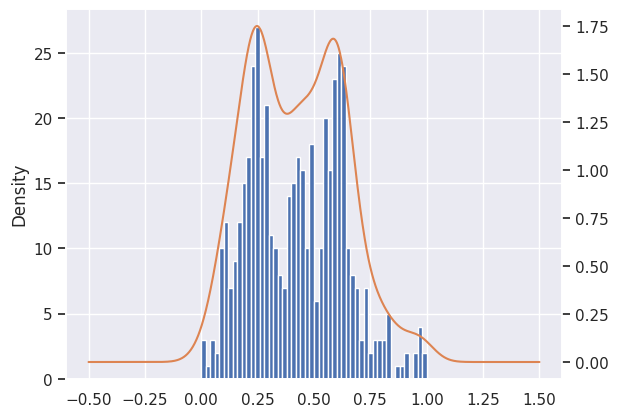

In [18]:
sns.set()
ax = dfy.plot.hist(bins=50,)
dfy.plot.kde(ax=ax, secondary_y=True)

ax.get_legend().remove()
plt.show()